## 6.6 Time Series Analysis

In [1]:
#Importing libraries

import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import warnings 

warnings.filterwarnings("ignore") 
plt.style.use('fivethirtyeight')

In [2]:
# Configuring API key 

quandl.ApiConfig.api_key = '-9Q_W8Ry9s-kBxY54tTP'

In [3]:
# Importing the US Federal Reserve Data Releases "Insurance companies and pension funds; prepayment of 
# insurance premiums and reserves for outstanding claims; liability (IMA), Quarterly, Transactions, SA" variable.

data = quandl.get('FED/FA583155005_Q')

In [4]:
data.head()

,Value
Date,
1946-12-31,932.0
1947-12-31,940.0
1948-12-31,933.0
1949-12-31,874.0
1950-12-31,757.0


In [5]:
data.tail(5)

,Value
Date,
2022-06-30,151320.0
2022-09-30,205640.0
2022-12-31,95292.0
2023-03-31,209676.0
2023-06-30,163516.0


In [6]:
data.shape

(292, 1)

In [7]:
data.columns

Index(['Value'], dtype='object')

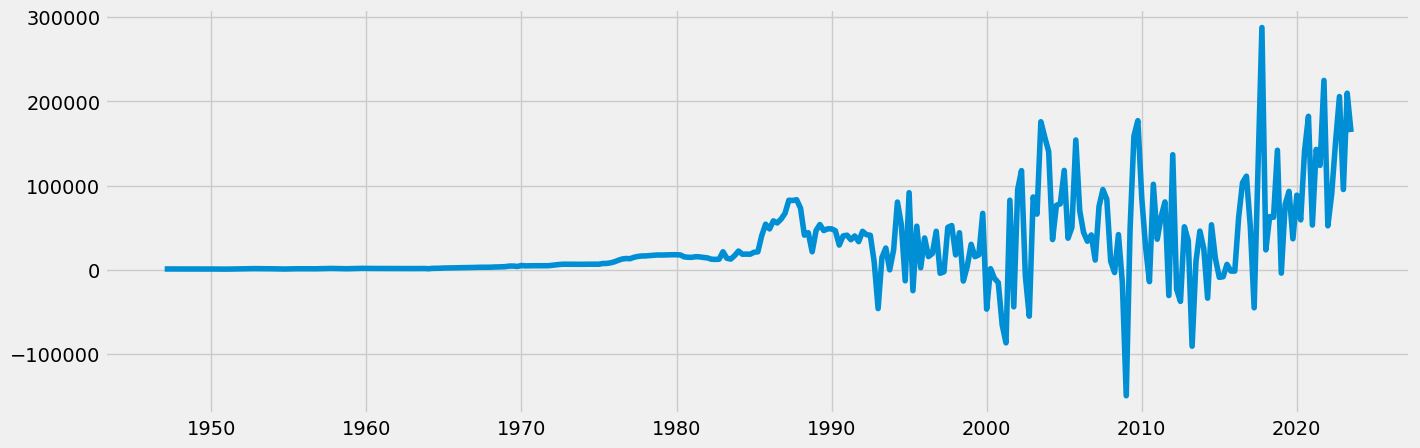

In [8]:
#Plotting the variable to see raw trends 

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data)

## Wrangling and Cleaning Time Series Data

In [9]:
# Reset index so that you can use the "Date" column as a filter

data_2 = data.reset_index()

In [10]:
data_2.head()

,Date,Value
0,1946-12-31,932.0
1,1947-12-31,940.0
2,1948-12-31,933.0
3,1949-12-31,874.0
4,1950-12-31,757.0


In [11]:
data_2.columns

Index(['Date', 'Value'], dtype='object')

In [12]:
data_2['Date'].max()

Timestamp('2023-06-30 00:00:00')

In [13]:
#Subsetting because data previous to 1980 would not be current or relevant

data_sub = data_2.loc[(data_2['Date'] >= '1980-01-01')]

In [14]:
data_sub.shape

(174, 2)

In [15]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,Value
datetime,
1980-03-31,17584.0
1980-06-30,15308.0
1980-09-30,14808.0
1980-12-31,14796.0
1981-03-31,15532.0


In [16]:
# Checking for null values -- None found

data_sub.isnull().sum()

Value    0
dtype: int64

In [17]:
# Checking for duplicates

dups = data_sub.duplicated()
dups.sum()


0

In [18]:
dups

datetime
1980-03-31    False
1980-06-30    False
1980-09-30    False
1980-12-31    False
1981-03-31    False
              ...  
2022-06-30    False
2022-09-30    False
2022-12-31    False
2023-03-31    False
2023-06-30    False
Length: 174, dtype: bool

In [19]:
#Dropping duplicates

data_clean = data_sub.drop_duplicates()

In [20]:
data_clean.shape

(174, 1)

In [21]:
data_clean.columns

Index(['Value'], dtype='object')

In [22]:
data_clean['Value'].dtype

dtype('float64')

In [23]:
print(data_clean.index.min())
print(data_clean.index.max())

1980-03-31 00:00:00
2023-06-30 00:00:00


In [24]:
data_clean['Value'].min()

-149580.0

In [25]:
data_clean['Value'].max()

287604.0

## Time Series Decomposition

In [26]:
# Decompose the time series using an additive model

from statsmodels.tsa.seasonal import seasonal_decompose

result_add = seasonal_decompose(data_clean, model = 'additive', extrapolate_trend='freq')


In [27]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

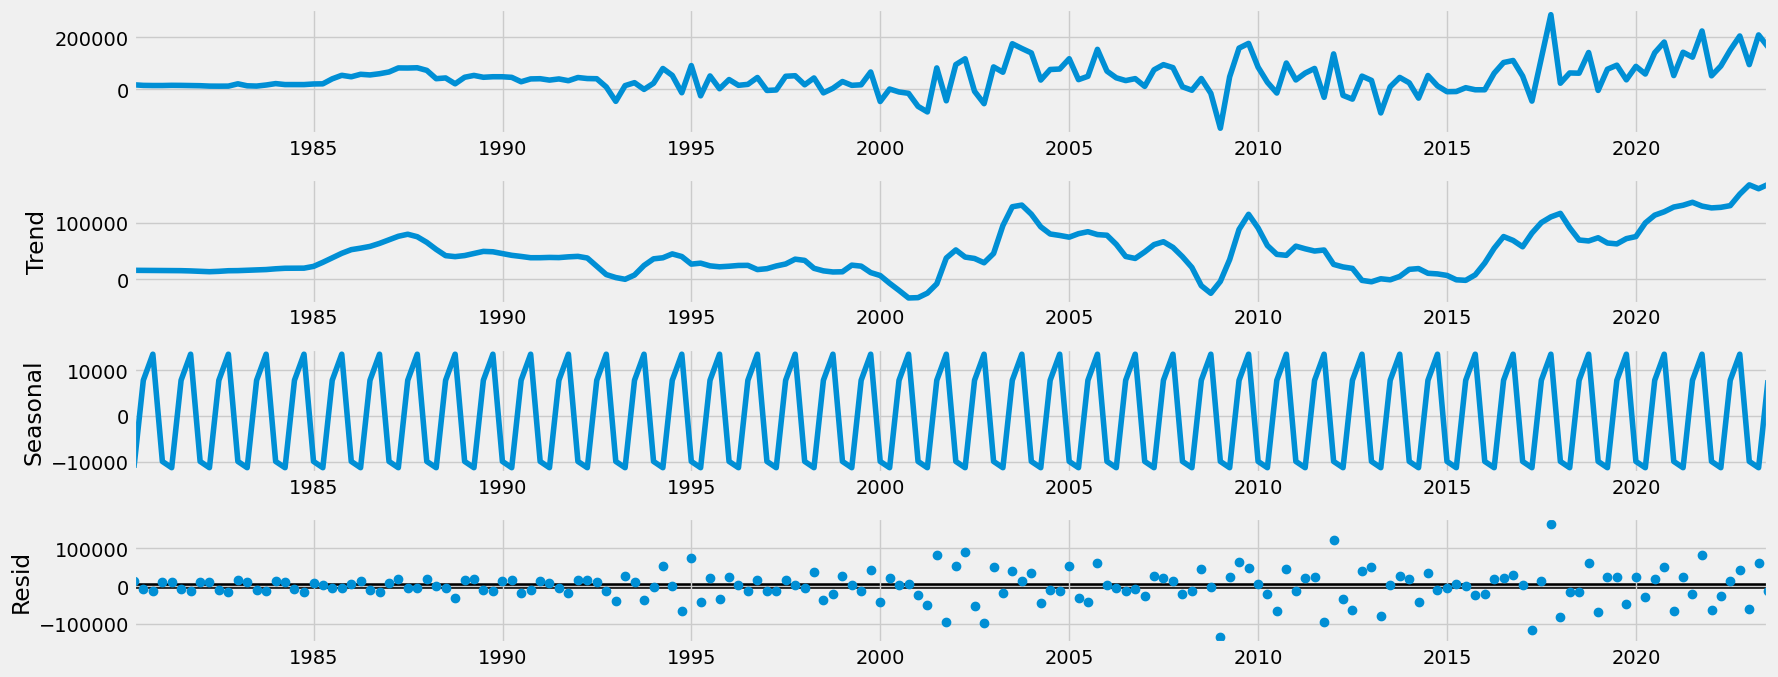

In [28]:
# Plotting the separate components

result_add.plot()
plt.show()

## Testing for Stationarity

In [29]:
# Importing the adfuller() function

from statsmodels.tsa.stattools import adfuller 

def dickey_fuller(timeseries): 
    
    # Performing the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_clean['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                  -3.116373
p-value                          0.025365
Number of Lags Used              3.000000
Number of Observations Used    170.000000
Critical Value (1%)             -3.469413
Critical Value (5%)             -2.878696
Critical Value (10%)            -2.575917
dtype: float64


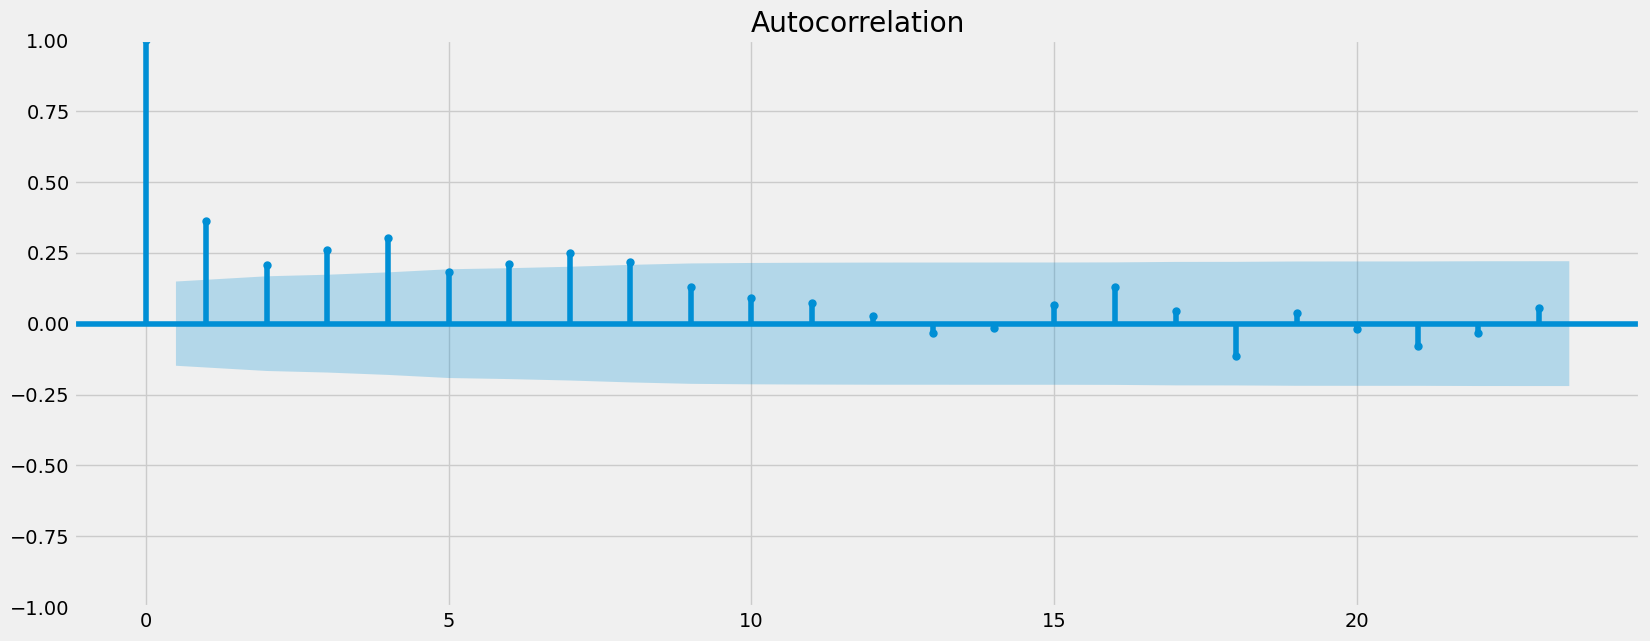

In [30]:
# Plotting autocorrelation

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

plot_acf(data_clean)
plt.show()

## Stationarizing Time Series Data

In [31]:
# Turning data to t - (t -1)

data_diff = data_clean - data_clean.shift(1)

In [32]:
# Dropping missing values

data_diff.dropna(inplace = True)

In [33]:
data_diff.head()

,Value
datetime,
1980-06-30,-2276.0
1980-09-30,-500.0
1980-12-31,-12.0
1981-03-31,736.0
1981-06-30,-260.0


In [34]:
data_diff.columns

Index(['Value'], dtype='object')

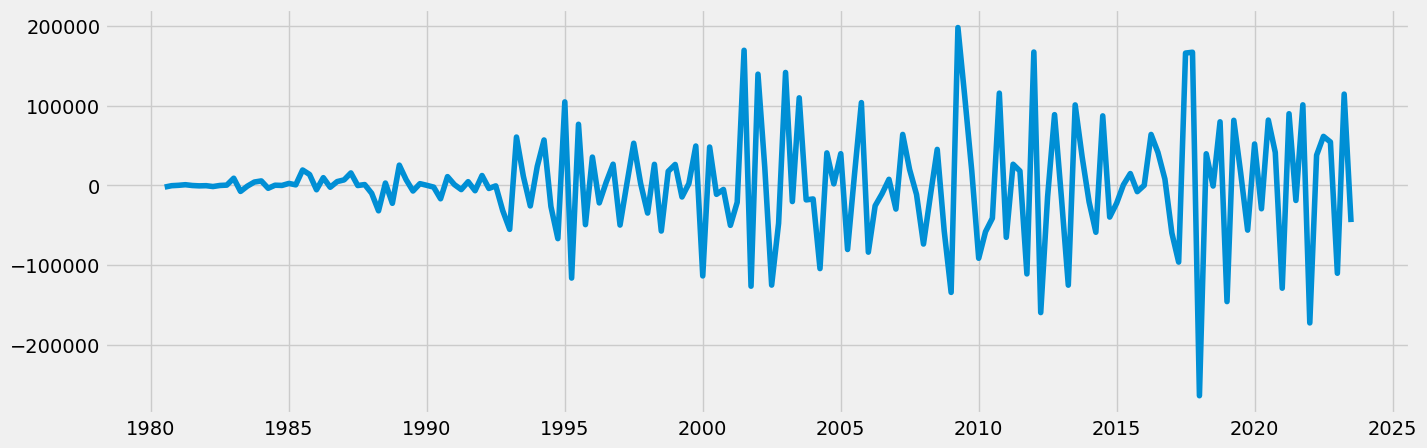

In [35]:
# Finding out how the differencing changed the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [36]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -8.122367e+00
p-value                        1.146951e-12
Number of Lags Used            6.000000e+00
Number of Observations Used    1.660000e+02
Critical Value (1%)           -3.470370e+00
Critical Value (5%)           -2.879114e+00
Critical Value (10%)          -2.576139e+00
dtype: float64


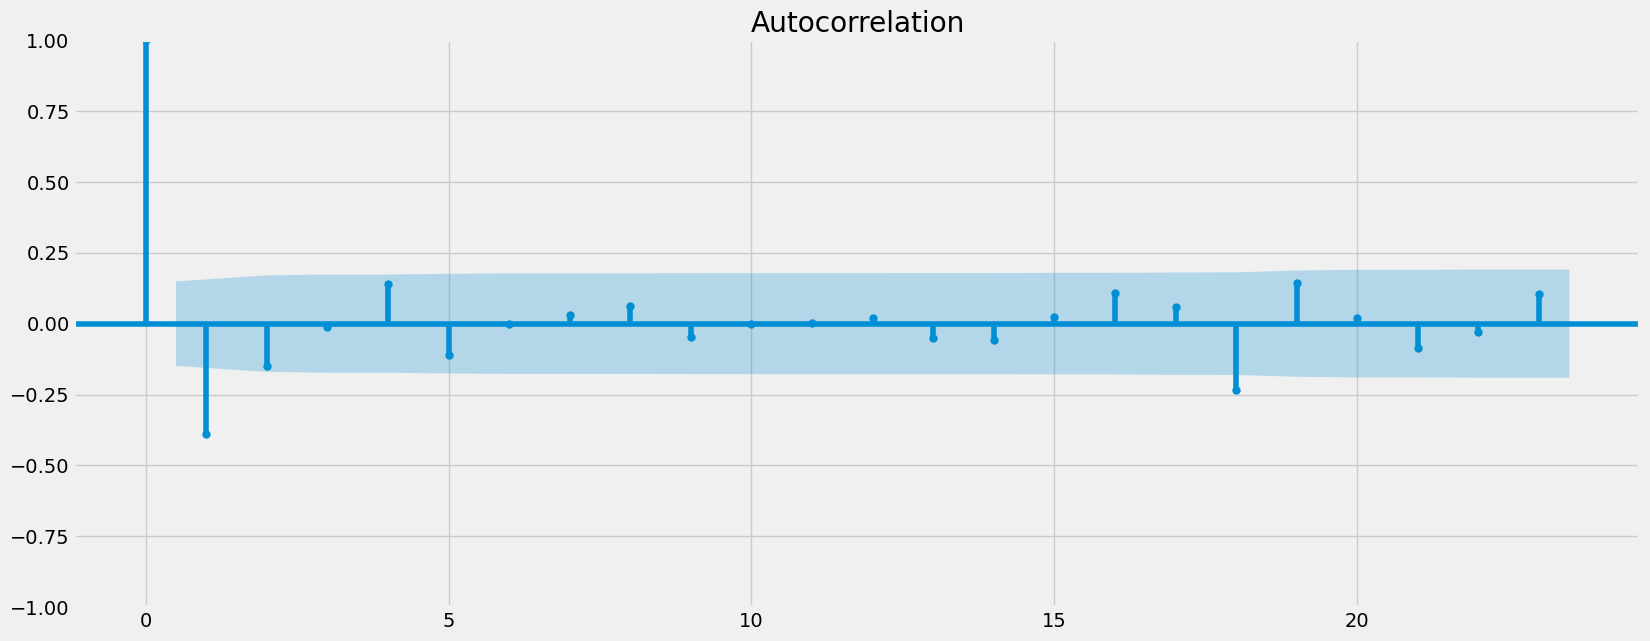

In [37]:
plot_acf(data_diff)
plt.show()